## Módulo 15 - Clusterização Hierárquica

In [47]:
# EAD / DV
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# statistics and maths
import numpy as np

# ML
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# HP optimization
import optuna 

# save model
import joblib

### Bloco 1 - AED

#### Carga dos Dados

Iniciamos a parte prática do módulo de classificação hierárquica com um projeto de Marketplace de Laptops. Demonstramos a configuração do ambiente no Visual Code e a importação de bibliotecas como Pandas, Seaborn e Scikit-learn. Em seguida, carregamos e analisamos a estrutura do dataset, explicando as colunas presentes. Mostramos os primeiros e últimos registros do dataset e destaca variáveis importantes como preço e rating. Essa etapa prepara o terreno para a análise exploratória dos dados.

In [2]:
df_laptops = pd.read_csv(filepath_or_buffer='../datasets/raw/dataset_laptops.csv')
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

**Dadaframe colunms description:**

- index: Appears to be a simple row identifier.
- brand: Brand of the laptop.
- model: Model description of the laptop.
- price: Price of the laptop in some currency.
- rating: Rating given to the laptop.
- processor_brand: Brand of the processor.
- processor_tier: Type or tier of the processor (e.g., Core i3, Ryzen 5).
- num_cores: Number of processor cores.
- num_threads: Number of threads.
- ram_memory: RAM capacity in GB.
- primary_storage_type: Type of primary storage (e.g., SSD, HDD).
- primary_storage_capacity: Capacity of the primary storage in GB.
- gpu_brand: Brand of the GPU.
- gpu_type: Type of GPU (integrated or dedicated).
- is_touch_screen: Boolean indicating if the laptop has a touchscreen.
- display_size: Size of the display in inches.
- resolution_width: Width of the screen resolution in pixels.
- resolution_height: Height of the screen resolution in pixels.
- os: Operating system.
- year_of_warranty: Warranty period in years.

In [3]:
df_laptops.head(n=5)

,index,brand,model,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty
0,1,tecno,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,287.72,63,intel,core i3,2,4,8,SSD,512,intel,integrated,False,15.6,1920,1080,windows,1
1,2,tecno,Tecno Megabook T1 Laptop (11th Gen Core i7/ 16...,431.64,67,intel,core i7,4,8,16,SSD,1024,intel,integrated,False,15.6,1920,1080,windows,1
2,3,hp,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,612.86,73,amd,ryzen 5,6,12,8,SSD,512,amd,dedicated,False,15.6,1920,1080,windows,1
3,4,acer,Acer Extensa EX214-53 Laptop (12th Gen Core i5...,479.62,62,intel,core i5,12,16,8,SSD,512,intel,integrated,False,14.0,1920,1080,windows,1
4,5,lenovo,Lenovo V15 82KDA01BIH Laptop (AMD Ryzen 3 5300...,342.77,62,amd,ryzen 3,4,8,8,SSD,512,amd,integrated,False,15.6,1920,1080,windows,1


#### Limpeza dos Dados

Neste resumo, abordamos a importância da análise exploratória de dados (EDA) em um projeto prático. Destacamos a análise estatística de variáveis como preço e rating, observando valores variados. Discutimos a necessidade de transformar variáveis categóricas em numéricas, exemplificando a correção da variável "year of warrant". Explicamos o uso do comando "loc" para ajustar valores e tipos de variáveis, como converter de booleano para inteiro. Essas etapas são essenciais para preparar os dados antes de aplicar algoritmos.

In [4]:
# checar varipavel year_of_warranty
df_laptops['year_of_warranty'].unique()

array(['1', '2', 'No information', '3'], dtype=object)

In [5]:
df_laptops.loc[df_laptops['year_of_warranty'] == 'No information', 'year_of_warranty'] = 1
df_laptops['year_of_warranty'] = df_laptops['year_of_warranty'].astype(dtype=int)	

In [6]:
# transform boollean to int - variable 'is_touch_screen'
df_laptops['is_touch_screen'] = df_laptops['is_touch_screen'].astype(dtype=int)

In [7]:
df_laptops.describe()

,index,price,rating,num_cores,num_threads,ram_memory,primary_storage_capacity,is_touch_screen,display_size,resolution_width,resolution_height,year_of_warranty
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,505.860747,926.687487,63.931382,8.128153,12.191726,13.047427,610.938446,0.088799,15.171241,2003.503532,1181.227043,1.083754
std,287.899458,688.239764,10.190575,4.215499,5.585115,5.591188,266.927666,0.284597,0.938089,361.965292,263.884019,0.311478
min,1.000000,117.540000,24.000000,2.000000,0.000000,2.000000,32.000000,0.000000,10.100000,1080.000000,768.000000,1.000000
25%,258.500000,522.850000,58.000000,6.000000,8.000000,8.000000,512.000000,0.000000,14.000000,1920.000000,1080.000000,1.000000
50%,507.000000,742.390000,64.000000,8.000000,12.000000,16.000000,512.000000,0.000000,15.600000,1920.000000,1080.000000,1.000000
75%,754.500000,1070.350000,71.000000,10.000000,16.000000,16.000000,512.000000,0.000000,15.600000,1920.000000,1200.000000,1.000000
max,1002.000000,5450.880000,89.000000,24.000000,32.000000,36.000000,2048.000000,1.000000,18.000000,3840.000000,2560.000000,3.000000


In [8]:
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     991 non-null    int64  
 1   brand                     991 non-null    object 
 2   model                     991 non-null    object 
 3   price                     991 non-null    float64
 4   rating                    991 non-null    int64  
 5   processor_brand           991 non-null    object 
 6   processor_tier            991 non-null    object 
 7   num_cores                 991 non-null    int64  
 8   num_threads               991 non-null    int64  
 9   ram_memory                991 non-null    int64  
 10  primary_storage_type      991 non-null    object 
 11  primary_storage_capacity  991 non-null    int64  
 12  gpu_brand                 991 non-null    object 
 13  gpu_type                  991 non-null    object 
 14  is_touch_s

#### Análise Univariada

In [9]:
percentual_brand = df_laptops.value_counts(subset='brand') / len(df_laptops) * 100
px.bar(data_frame=percentual_brand, color=percentual_brand.index)

In [10]:
# processor_brand distribution
percentual_processor_brand = df_laptops.value_counts(
    subset='processor_brand') / len(df_laptops) * 100
px.bar(data_frame=percentual_processor_brand, color=percentual_processor_brand.index)

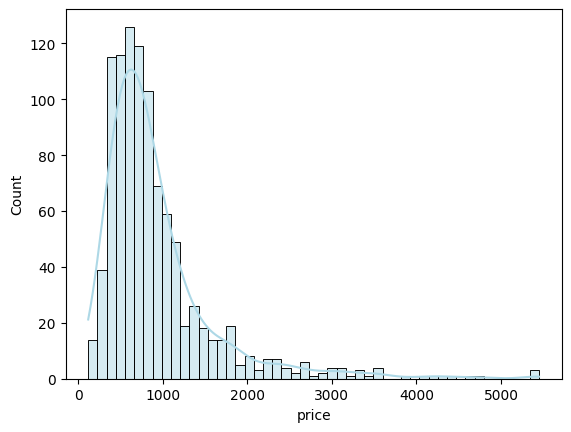

In [11]:
# price distribution
sns.histplot(data=df_laptops['price'], kde=True, color='lightblue')
plt.show()

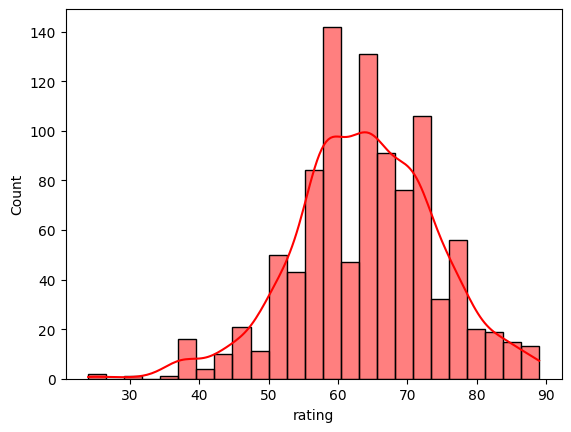

In [12]:
# rating distribution
sns.histplot(data=df_laptops['rating'], kde=True, color='red')
plt.show()

#### Análise Bivariada

Neste trecho da aula, finalizamos a análise exploratória de dados (EDA) antes de avançar para a clusterização. Mostramos como analisar a correlação entre a marca e o preço dos laptops usando boxplots. Demonstramos também a relação entre o rating e as marcas, e por fim, exploramos a relação entre preço e rating, destacando que não há uma correlação forte entre essas variáveis. Essas análises são essenciais para organizar os laptops em grupos e fazer recomendações.

In [13]:
# price x brand distribution boxplot
px.box(data_frame=df_laptops, x='price', y='brand', color='brand', orientation='h')

In [14]:
# rating x brand distribution boxplot
px.box(data_frame=df_laptops, x='rating', y='brand', color='brand', orientation='h')

In [15]:
# price x rating distribution
px.scatter(df_laptops, x='price', y='rating', color='brand')

### Bloco 3 - Treinamento do Modelo


#### Transformar Dados para o Modelo

In [16]:
df_laptops_transformed = df_laptops.copy()

# drop unnecessary columns 'index' and 'model'
df_laptops_transformed.drop(columns=['index', 'model'], axis=1, inplace=True)

df_laptops_transformed

,brand,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,primary_storage_type,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty
0,tecno,287.72,63,intel,core i3,2,4,8,SSD,512,intel,integrated,0,15.6,1920,1080,windows,1
1,tecno,431.64,67,intel,core i7,4,8,16,SSD,1024,intel,integrated,0,15.6,1920,1080,windows,1
2,hp,612.86,73,amd,ryzen 5,6,12,8,SSD,512,amd,dedicated,0,15.6,1920,1080,windows,1
3,acer,479.62,62,intel,core i5,12,16,8,SSD,512,intel,integrated,0,14.0,1920,1080,windows,1
4,lenovo,342.77,62,amd,ryzen 3,4,8,8,SSD,512,amd,integrated,0,15.6,1920,1080,windows,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,asus,791.44,68,amd,ryzen 5,6,12,16,SSD,512,nvidia,dedicated,0,15.6,1920,1080,windows,1
987,msi,1103.27,73,intel,core i7,10,16,16,SSD,512,nvidia,dedicated,0,15.6,1920,1080,windows,2
988,asus,539.58,59,amd,ryzen 5,4,8,8,SSD,512,amd,integrated,0,15.6,1920,1080,windows,1
989,asus,815.43,68,amd,ryzen 5,6,12,16,SSD,512,amd,integrated,0,14.0,2560,1600,windows,1


In [17]:
# separete categorical and numerical columns
numeric_features = ['price', 'rating', 'num_cores', 'num_threads', 'ram_memory', 'primary_storage_capacity', 'resolution_width', 'resolution_height', 'display_size']
categorical_features = ['brand', 'processor_brand', 'gpu_brand', 'gpu_type', 'os']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder() 

preprocessor = ColumnTransformer(
    transformers= [
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

df_laptops_encoded = preprocessor.fit_transform(X=df_laptops_transformed)
df_laptops_encoded

<991x54 sparse matrix of type '<class 'numpy.float64'>'
	with 13874 stored elements in Compressed Sparse Row format>

#### Criar Função Otimização Algoritmo Aglomerativo

Neste trecho, explicamos como trabalhar com modelos de clustering hierárquico aglomerativo, utilizando o Optuna para escolher os melhores hiperparâmetros. Destacamos a importância de definir a quantidade de clusters de forma estratégica para facilitar a recomendação de máquinas em um sistema de recomendação. Abordamos também os critérios de linkage, como Ward, average, complete e single, para aglomeração de clusters. Finalizamos preparando a função para otimização do Silhouette Score e a criação do estudo para rodar o modelo.

In [18]:
def hierarchical_aglomerative_clustering(trial: optuna.Trial) -> AgglomerativeClustering:
    n_clusters = trial.suggest_int(name='n_clusters', low=10, high=150)
    
    # linkage = criteria to determine the distance between two clusters
    # ward = variance
    # average = median
    # complete = max
    # single = min
    linkage = trial.suggest_categorical(name='linkage', choices=['ward', 'average', 'complete', 'single'])
    
    # initialize model
    hierarchical_aglomerative_clustering_model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)
    
    # fit model
    y = hierarchical_aglomerative_clustering_model.fit_predict(X=df_laptops_encoded.toarray())
    
    # calculate silhouette average
    silhouette_avg = silhouette_score(X=df_laptops_encoded, labels=y)
    
    return silhouette_avg    

#### Execução Otimização Algoritmo Aglomerativo

Neste trecho da aula, foi criada uma função chamada no Optuna para realizar um estudo de otimização de parâmetros. Foram definidos os espaços de busca para as variáveis `n_clusters` e `linkage`, e um `sampler Grid` foi utilizado para explorar todas as opções possíveis. Foi criado um estudo para maximizar o `Silhouette Score` e executar 564 trials. O melhor resultado obtido foi um `Silhouette Score` de 0,32745 com 149 clusters e linkage do tipo `ward`. Os modelos aglomerativo e divisivo serão comparados para determinar o melhor a ser salvo.

In [19]:
# create study with GridSampler(optuna)  and maximize value of 'n_clusters' parameter 
search_space = {'n_clusters': range(10, 150), 'linkage': ['ward', 'average', 'complete', 'single']}
sampler_agg = optuna.samplers.GridSampler(search_space=search_space)
study_agg = optuna.create_study(study_name='agglomerative_study', direction='maximize', sampler=sampler_agg)

[I 2024-05-15 08:22:32,373] A new study created in memory with name: agglomerative_study


In [20]:
# optimize study with 600 trials
study_agg.optimize(func=hierarchical_aglomerative_clustering, n_trials=600)

[I 2024-05-15 08:22:32,480] Trial 0 finished with value: 0.26386925251910803 and parameters: {'n_clusters': 101, 'linkage': 'ward'}. Best is trial 0 with value: 0.26386925251910803.
[I 2024-05-15 08:22:32,561] Trial 1 finished with value: 0.1341021376087075 and parameters: {'n_clusters': 28, 'linkage': 'complete'}. Best is trial 0 with value: 0.26386925251910803.
[I 2024-05-15 08:22:32,637] Trial 2 finished with value: 0.05436585966019915 and parameters: {'n_clusters': 140, 'linkage': 'single'}. Best is trial 0 with value: 0.26386925251910803.
[I 2024-05-15 08:22:32,707] Trial 3 finished with value: 0.22169442555754082 and parameters: {'n_clusters': 138, 'linkage': 'complete'}. Best is trial 0 with value: 0.26386925251910803.
[I 2024-05-15 08:22:32,780] Trial 4 finished with value: 0.2273522361563746 and parameters: {'n_clusters': 49, 'linkage': 'ward'}. Best is trial 0 with value: 0.26386925251910803.
[I 2024-05-15 08:22:32,857] Trial 5 finished with value: -0.03894495250452619 and pa

In [21]:
# best parameters 
best_params_agg = study_agg.best_params

# print results
print(f'Clusters: {best_params_agg["n_clusters"]}')
print(f'Linkage: {best_params_agg['linkage']}')

Clusters: 149
Linkage: ward


#### Criar Função e Execução Otimização Algoritmo Divisivo

Neste trecho da aula, foi abordado o treinamento de modelos de clustering divisivo. Foi utilizado o modelo Bisecting K-Means para criar clusters hierárquicos divisivos. O instrutor explicou a adaptação do código para esse tipo de modelo, destacando a importância do parâmetro de quantidade de clusters. Além disso, foi mencionado o uso do Optuna para otimização de hiperparâmetros. Ao final, foi comparado o desempenho dos modelos divisivo e aglomerativo, sendo este último escolhido como a melhor abordagem.

In [22]:
def hierarchical_divisive_clustering(trial: optuna.Trial) -> BisectingKMeans:
    
    # n_clusters = number of clusters to form 
    n_clusters = trial.suggest_int(name='n_clusters', low=10, high=150)

    # initialize model
    hierarchical_divisive_clustering_model = BisectingKMeans(n_clusters=n_clusters)

    # fit model
    y = hierarchical_divisive_clustering_model.fit_predict(
        X=df_laptops_encoded.toarray())

    # calculate silhouette average
    silhouette_avg = silhouette_score(X=df_laptops_encoded, labels=y)

    return silhouette_avg

In [23]:
# create study with GridSampler(optuna)  and maximize value of 'n_clusters' parameter
search_space_div = {'n_clusters': range(10, 150)}
sampler_div = optuna.samplers.GridSampler(search_space=search_space_div)
study_div = optuna.create_study(
    study_name='divisive_study', direction='maximize', sampler=sampler_div)

[I 2024-05-15 08:24:09,900] A new study created in memory with name: divisive_study


In [24]:
# optimize study with 600 trials
study_div.optimize(func=hierarchical_divisive_clustering, n_trials=200)

[I 2024-05-15 08:24:10,648] Trial 0 finished with value: 0.14673371437419716 and parameters: {'n_clusters': 26}. Best is trial 0 with value: 0.14673371437419716.
[I 2024-05-15 08:24:11,021] Trial 1 finished with value: 0.16642572026020383 and parameters: {'n_clusters': 92}. Best is trial 1 with value: 0.16642572026020383.
[I 2024-05-15 08:24:11,421] Trial 2 finished with value: 0.15678616569160161 and parameters: {'n_clusters': 97}. Best is trial 1 with value: 0.16642572026020383.
[I 2024-05-15 08:24:11,886] Trial 3 finished with value: 0.18062486850695247 and parameters: {'n_clusters': 126}. Best is trial 3 with value: 0.18062486850695247.
[I 2024-05-15 08:24:12,273] Trial 4 finished with value: 0.16743444214209494 and parameters: {'n_clusters': 105}. Best is trial 3 with value: 0.18062486850695247.
[I 2024-05-15 08:24:12,743] Trial 5 finished with value: 0.17596487383401052 and parameters: {'n_clusters': 117}. Best is trial 3 with value: 0.18062486850695247.
[I 2024-05-15 08:24:12,91

In [25]:
# best parameters
best_params_div = study_div.best_params

# print results
print(f'Clusters: {best_params_div["n_clusters"]}')

Clusters: 142


#### Criar Melhor Modelo e Atribuir Clusters ao Dataset

Neste trecho da aula, é abordado o treinamento do modelo aglomerativo para atribuir valores aos clusters obtidos. São detalhados os parâmetros necessários para criar e treinar o modelo, bem como a importância de atribuir os labels aos registros do DataFrame original. Demonstrou-se como obter o silhouette score e como atribuir os clusters aos registros, mantendo a integridade do DataFrame. Ao final, destaca a importância desses clusters para a próxima etapa do projeto prático.

In [26]:
# best model Agglomerative Clustering
best_model = AgglomerativeClustering(
    n_clusters=best_params_agg['n_clusters'], linkage=best_params_agg['linkage'])

# fit best model
best_model.fit(df_laptops_encoded.toarray())

AgglomerativeClustering(n_clusters=149)

In [27]:
# calculate best score
best_score = silhouette_score(X=df_laptops_encoded, labels=best_model.labels_)
best_score

0.32745480721431686

In [28]:
# add 'cluster' column to df laptops with best model labels 
df_laptops['cluster'] = best_model.labels_
df_laptops.head()

,index,brand,model,price,rating,processor_brand,processor_tier,num_cores,num_threads,ram_memory,...,primary_storage_capacity,gpu_brand,gpu_type,is_touch_screen,display_size,resolution_width,resolution_height,os,year_of_warranty,cluster
0,1,tecno,Tecno Megabook T1 Laptop (11th Gen Core i3/ 8G...,287.72,63,intel,core i3,2,4,8,...,512,intel,integrated,0,15.6,1920,1080,windows,1,73
1,2,tecno,Tecno Megabook T1 Laptop (11th Gen Core i7/ 16...,431.64,67,intel,core i7,4,8,16,...,1024,intel,integrated,0,15.6,1920,1080,windows,1,44
2,3,hp,HP Victus 15-fb0157AX Gaming Laptop (AMD Ryzen...,612.86,73,amd,ryzen 5,6,12,8,...,512,amd,dedicated,0,15.6,1920,1080,windows,1,28
3,4,acer,Acer Extensa EX214-53 Laptop (12th Gen Core i5...,479.62,62,intel,core i5,12,16,8,...,512,intel,integrated,0,14.0,1920,1080,windows,1,53
4,5,lenovo,Lenovo V15 82KDA01BIH Laptop (AMD Ryzen 3 5300...,342.77,62,amd,ryzen 3,4,8,8,...,512,amd,integrated,0,15.6,1920,1080,windows,1,14


### Bloco 3 - Análise dos Resultados

#### Geração e Uso do Dendrograma

Neste trecho da aula, foi mostrado como visualizar os resultados da atribuição de clusters em um DataFrame. Foi utilizado o Optuna para gerar um gráfico mostrando a evolução dos trials. Em seguida, foi explicado como gerar um dendrograma, utilizando o Scipy para realizar um clustering hierárquico aglomerativo. Foi demonstrado como cortar o dendrograma para obter diferentes números de clusters. Essas técnicas são essenciais para analisar e interpretar os resultados de modelos de clustering.

In [29]:
# create figure 
fig = optuna.visualization.plot_optimization_history(study_agg)
fig.show()

In [33]:
# train scipy model
dendrogram_model = linkage(y=df_laptops_encoded.toarray(), method=best_params_agg['linkage'], optimal_ordering=True)

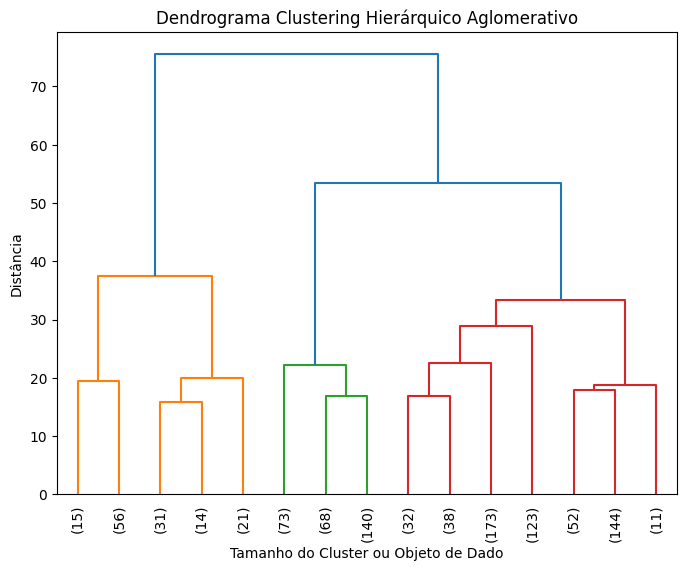

In [37]:
# plot dendrogram
plt.figure(figsize=(8,6))
dendrogram(Z=dendrogram_model, truncate_mode='lastp', p=15, leaf_rotation=90, leaf_font_size=10)
plt.title(label="Dendrograma Clustering Hierárquico Aglomerativo")
plt.xlabel(xlabel="Tamanho do Cluster ou Objeto de Dado")
plt.ylabel(ylabel="Distância")
plt.show()

In [38]:
# cut dendrogram
clusters_dendrogram_scipy = cut_tree(Z=dendrogram_model, height=32)
len(np.unique(clusters_dendrogram_scipy))

5

#### Visualizar Resultados da Clusterização

In [40]:
# plot brand x price distribution by clusters 
px.scatter(data_frame=df_laptops, x='brand', y='price', color='cluster')

In [41]:
px.scatter(data_frame=df_laptops, x='cluster', y='price', color='brand')

In [43]:
px.scatter(data_frame=df_laptops, x='brand', y='rating', color='cluster')

In [44]:
px.scatter(data_frame=df_laptops, x='cluster', y='rating', color='brand')

In [45]:
# cluster distribution
percentual_cluster = df_laptops.value_counts(subset='cluster') / len(df_laptops) * 100
px.bar(data_frame=percentual_cluster, color=percentual_cluster.index)

In [46]:
# cluster quantity distribution
qtd_cluster = df_laptops.value_counts(subset='cluster')
px.bar(data_frame=qtd_cluster, color=qtd_cluster.index)

#### Salvar Modelo e Dataset

Neste trecho, é abordado o processo de salvar o modelo, o pipeline e o pré-processador em um arquivo utilizando a biblioteca Joblib. Além disso, é mencionado o salvamento de um arquivo CSV com informações de cluster para ser utilizado em uma aplicação Streamlit. O modelo é salvo como "modelo_clusterizacao_laptops.pkl" e o pré-processador como "preprocessor_clusterizacao_laptops.pkl". O CSV é salvo como "clusterizacao_laptops.csv" sem o índice como coluna. Esses arquivos serão utilizados na aplicação para recomendação de notebooks.

In [48]:
# save model
joblib.dump(value=best_model, filename='../models/model_clustering_laptops.pkl' )

# save pipeline
joblib.dump(value=preprocessor, filename='../pipelines/pipeline_clustering_laptops.pkl')

['../pipelines/pipeline_clustering_laptops.pkl']

In [49]:
# save processed dataframe
df_laptops.to_csv(path_or_buf='../datasets/processed/laptops_clusters.csv', index=False)